# Example 16 - Unconformal Faulted Folded Layers

This example will show how to convert the geological map below using ``GemGIS`` to a `GemPy` model. This example is based on digitized data. The area is 3968 m wide (W-E extent) and 2731 m high (N-S extent). The model represents folded and faulted layers as well as layers separated by an unconfirmity. 


The map has been georeferenced with QGIS. The stratigraphic boundaries were digitized in QGIS. Strikes lines were digitized in QGIS as well and will be used to calculate orientations for the `GemPy` model. The contour lines were also digitized and will be interpolated with `GemGIS` to create a topography for the model. 

<img src="../images/cover_example16.png" width="800">

Map Source: An Introduction to Geological Structures and Maps by G.M. Bennison

## Import GemGIS

If you have installed ``GemGIS`` via pip, you can import ``GemGIS`` like any other package. If you have downloaded the repository, append the path to the directory where the ``GemGIS`` repository is stored and then import ``GemGIS``. 

In [1]:
import warnings
warnings.filterwarnings("ignore")
import gemgis as gg

## Importing Libraries and loading Data

All remaining packages can be loaded in order to prepare the data and to construct the model. The example data is downloaded from an external server using `pooch`. It will be stored in a data folder in the same directory where this notebook is stored.  

In [2]:
import geopandas as gpd
import rasterio 

In [3]:
file_path = 'data/example16/'
gg.download_gemgis_data.download_tutorial_data(filename="example16_all_features.zip", dirpath=file_path)

## Creating Digital Elevation Model from Contour Lines

The digital elevation model (DEM) will be created by interpolating contour lines digitized from the georeferenced map using the `SciPy` Radial Basis Function interpolation wrapped in `GemGIS`. The respective function used for that is `gg.vector.interpolate_raster()`. 

<img src="../images/dem_example16.png" width="800">

In [4]:
topo = gpd.read_file(file_path + 'topo16.shp')
topo.head()

,id,Z,geometry
0,None,200,"LINESTRING (1.591 265.171, 32.840 230.967, 79...."
1,None,200,"LINESTRING (2.436 851.918, 33.473 889.712, 73...."
2,None,100,"LINESTRING (1.803 2469.855, 62.188 2493.502, 1..."
3,None,200,"LINESTRING (2.014 2215.436, 17.849 2238.028, 6..."
4,None,900,"LINESTRING (3559.448 2.095, 3595.764 16.875, 3..."


### Interpolating the contour lines

In [5]:
topo_raster = gg.vector.interpolate_raster(gdf=topo, value='Z', method='rbf', res=10)

### Plotting the raster

Text(26.9506823456599, 0.5, 'Y [m]')

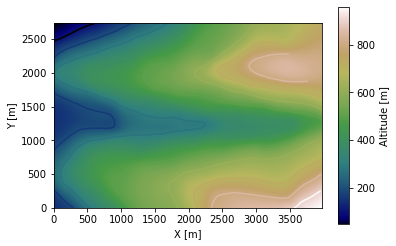

In [6]:
import matplotlib.pyplot as plt

fix, ax = plt.subplots(1)
topo.plot(ax=ax, aspect='equal', column='Z', cmap='gist_earth')
im = plt.imshow(topo_raster, origin='lower', extent=[0,3968,0,2731], cmap='gist_earth')
cbar = plt.colorbar(im)
cbar.set_label('Altitude [m]')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')

### Saving the raster to disc

After the interpolation of the contour lines, the raster is saved to disc using `gg.raster.save_as_tiff()`. The function will not be executed as a raster is already provided with the example data. 

### Opening Raster

The previously computed and saved raster can now be opened using rasterio. 

In [7]:
topo_raster = rasterio.open(file_path + 'raster16.tif')

## Interface Points of stratigraphic boundaries

The interface points will be extracted from LineStrings digitized from the georeferenced map using QGIS. It is important to provide a formation name for each layer boundary. The vertical position of the interface point will be extracted from the digital elevation model using the `GemGIS` function `gg.vector.extract_xyz()`. The resulting GeoDataFrame now contains single points including the information about the respective formation. 

<img src="../images/interfaces_example16.png" width="800">

In [8]:
interfaces = gpd.read_file(file_path + 'interfaces16.shp')
interfaces.head()

,id,formation,geometry
0,None,Fault,"LINESTRING (1401.636 2725.330, 1370.388 2586.8..."
1,None,H,"LINESTRING (3403.207 2406.937, 3334.799 2401.8..."
2,None,G,"LINESTRING (3290.883 2728.708, 3235.987 2687.3..."
3,None,D,"LINESTRING (3461.481 1326.764, 3425.165 1298.0..."
4,None,D,"LINESTRING (2837.362 1560.703, 2908.304 1494.8..."


### Extracting Z coordinate from Digital Elevation Model

In [9]:
interfaces_coords = gg.vector.extract_xyz(gdf=interfaces, dem=topo_raster)
interfaces_coords = interfaces_coords.sort_values(by='formation', ascending=False)
interfaces_coords = interfaces_coords[interfaces_coords['formation'].isin(['Fault', 'B', 'C', 'D', 'G', 'F', 'H'])]
interfaces_coords.head()

,formation,geometry,X,Y,Z
351,H,POINT (3476.260 416.767),3476.26,416.77,699.70
44,H,POINT (3711.466 1652.758),3711.47,1652.76,664.07
359,H,POINT (3109.728 291.774),3109.73,291.77,747.18
358,H,POINT (3185.737 288.818),3185.74,288.82,745.14
357,H,POINT (3244.855 294.308),3244.86,294.31,734.68


### Plotting the Interface Points

Text(35.5, 0.5, 'Y [m]')

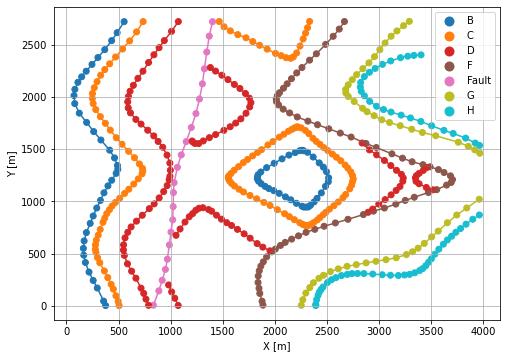

In [10]:
fig, ax = plt.subplots(1, figsize=(8,8))

interfaces.plot(ax=ax, column='formation', legend=True, aspect='equal')
interfaces_coords.plot(ax=ax, column='formation', legend=True, aspect='equal')
plt.grid()
plt.xlabel('X [m]')
plt.ylabel('Y [m]')

## Orientations from Strike Lines

Strike lines connect outcropping stratigraphic boundaries (interfaces) of the same altitude. In other words: the intersections between topographic contours and stratigraphic boundaries at the surface. The height difference and the horizontal difference between two digitized lines is used to calculate the dip and azimuth and hence an orientation that is necessary for `GemPy`. In order to calculate the orientations, each set of strikes lines/LineStrings for one formation must be given an id number next to the altitude of the strike line. The id field is already predefined in QGIS. The strike line with the lowest altitude gets the id number `1`, the strike line with the highest altitude the the number according to the number of digitized strike lines. It is currently recommended to use one set of strike lines for each structural element of one formation as illustrated. 

<img src="../images/orientations_example16.png" width="800">

In [11]:
strikes = gpd.read_file(file_path + 'strikes16.shp')
strikes.head()

,id,formation,Z,geometry
0,1,Fault2,300,"LINESTRING (1369.455 2575.828, 1108.966 1461.029)"
1,2,Fault2,400,"LINESTRING (1331.187 2325.368, 1176.529 1650.260)"
2,1,Fault1,400,"LINESTRING (1021.872 873.278, 846.365 36.387)"
3,2,Fault1,500,"LINESTRING (973.575 482.148, 931.611 286.847)"
4,2,B4,300,"LINESTRING (92.345 2105.786, 115.570 1859.812)"


### Calculate Orientations for each formation

In [12]:
orientations_f1 = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation']=='Fault1'].sort_values(by='Z', ascending=True).reset_index())
orientations_f1

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,72.24,281.86,450.00,POINT (943.356 419.665),1.00,Fault1,943.36,419.67


In [13]:
orientations_f2 = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation']=='Fault2'].sort_values(by='Z', ascending=True).reset_index())
orientations_f2

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,78.84,283.09,350.00,POINT (1246.534 2003.121),1.00,Fault2,1246.53,2003.12


In [14]:
orientations_f3 = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation']=='Fault3'].sort_values(by='Z', ascending=True).reset_index())
orientations_f3

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,72.65,281.34,350.00,POINT (1084.157 1262.429),1.00,Fault3,1084.16,1262.43


In [15]:
orientations_b1 = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation']=='B1'].sort_values(by='Z', ascending=True).reset_index())
orientations_b1

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,20.35,85.12,250.00,POINT (347.292 491.913),1.00,B1,347.29,491.91


In [16]:
orientations_b2 = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation']=='B2'].sort_values(by='Z', ascending=True).reset_index())
orientations_b2

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,21.95,265.66,350.00,POINT (2029.784 1223.500),1.00,B2,2029.78,1223.50


In [17]:
orientations_b3 = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation']=='B3'].sort_values(by='Z', ascending=True).reset_index())
orientations_b3

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,0.00,85.61,400.00,POINT (2282.355 1220.333),1.00,B3,2282.36,1220.33


In [18]:
orientations_b4 = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation']=='B4'].sort_values(by='Z', ascending=True).reset_index())
orientations_b4

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,21.87,85.18,250.00,POINT (230.639 1970.923),1.00,B4,230.64,1970.92


In [19]:
orientations_c1 = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation']=='C1'].sort_values(by='Z', ascending=True).reset_index())
orientations_c1

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,22.48,85.96,250.00,POINT (585.612 498.643),1.00,C1,585.61,498.64


In [20]:
orientations_c2 = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation']=='C2'].sort_values(by='Z', ascending=True).reset_index())
orientations_c2

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,22.41,264.42,350.00,POINT (1784.602 1228.779),1.00,C2,1784.60,1228.78
1,0.00,0.00,400.00,POINT (2032.159 1240.391),1.00,C2,2032.16,1240.39


In [21]:
orientations_c3 = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation']=='C3'].sort_values(by='Z', ascending=True).reset_index())
orientations_c3

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,11.47,85.21,450.00,POINT (2406.530 1229.571),1.00,C3,2406.53,1229.57
1,0.00,0.00,500.00,POINT (2284.863 1233.002),1.00,C3,2284.86,1233.00


In [22]:
orientations_c4 = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation']=='C4'].sort_values(by='Z', ascending=True).reset_index())
orientations_c4

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,22.59,265.72,350.00,POINT (1723.636 2004.441),1.00,C4,1723.64,2004.44
1,22.15,265.73,450.00,POINT (1968.554 2021.331),1.00,C4,1968.55,2021.33


In [23]:
orientations_c5 = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation']=='C5'].sort_values(by='Z', ascending=True).reset_index())
orientations_c5

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,21.62,85.70,250.00,POINT (475.557 1973.562),1.00,C5,475.56,1973.56


In [24]:
orientations_d1 = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation']=='D1'].sort_values(by='Z', ascending=True).reset_index())
orientations_d1

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,24.97,86.28,350.00,POINT (837.128 468.952),1.00,D1,837.13,468.95


In [25]:
orientations_d2 = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation']=='D2'].sort_values(by='Z', ascending=True).reset_index())
orientations_d2

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,0.00,85.37,400.00,POINT (3288.420 1212.416),1.00,D2,3288.42,1212.42
1,11.25,0.00,450.00,POINT (3159.890 1219.542),1.00,D2,3159.89,1219.54


In [26]:
orientations_d3 = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation']=='D3'].sort_values(by='Z', ascending=True).reset_index())
orientations_d3

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,22.81,266.11,450.00,POINT (1481.621 1955.879),1.00,D3,1481.62,1955.88


In [27]:
orientations_d4 = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation']=='D4'].sort_values(by='Z', ascending=True).reset_index())
orientations_d4

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,0.00,265.65,400.00,POINT (1283.945 1251.212),1.00,D4,1283.94,1251.21
1,11.48,0.00,450.00,POINT (1407.460 1235.905),1.00,D4,1407.46,1235.90


In [28]:
orientations_d5 = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation']=='D5'].sort_values(by='Z', ascending=True).reset_index())
orientations_d5

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,23.00,84.84,350.00,POINT (735.783 1952.448),1.00,D5,735.78,1952.45


In [29]:
orientations_g = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation']=='G'].sort_values(by='Z', ascending=True).reset_index())
orientations_g

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,5.85,89.87,650.00,POINT (3475.011 1339.361),1.00,G,3475.01,1339.36


### Merging Orientations

In [30]:
import pandas as pd
orientations = pd.concat([orientations_f1, orientations_f2, orientations_f3, orientations_b1, orientations_b2, orientations_b3, orientations_b4, orientations_c1, orientations_c2, orientations_c3, orientations_c4, orientations_c5, orientations_d1, orientations_d2, orientations_d3, orientations_d4, orientations_d5, orientations_g]).reset_index()
orientations['formation'] = ['Fault', 'Fault', 'Fault', 'B', 'B', 'B', 'B', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'G']
orientations = orientations[orientations['formation'].isin(['Fault', 'B', 'C', 'D', 'G'])]
orientations.head()

,index,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,0,72.24,281.86,450.00,POINT (943.356 419.665),1.00,Fault,943.36,419.67
1,0,78.84,283.09,350.00,POINT (1246.534 2003.121),1.00,Fault,1246.53,2003.12
2,0,72.65,281.34,350.00,POINT (1084.157 1262.429),1.00,Fault,1084.16,1262.43
3,0,20.35,85.12,250.00,POINT (347.292 491.913),1.00,B,347.29,491.91
4,0,21.95,265.66,350.00,POINT (2029.784 1223.500),1.00,B,2029.78,1223.50


### Plotting the Orientations

Text(35.5, 0.5, 'Y [m]')

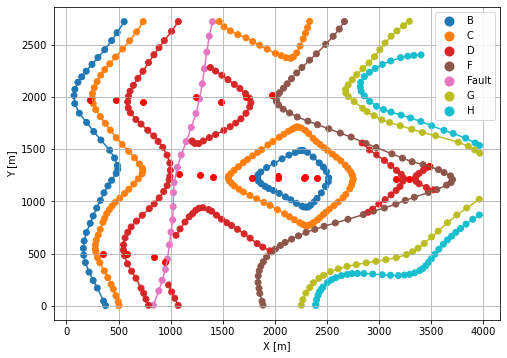

In [31]:
fig, ax = plt.subplots(1, figsize=(8,8))

interfaces.plot(ax=ax, column='formation', legend=True, aspect='equal')
interfaces_coords.plot(ax=ax, column='formation', legend=True, aspect='equal')
orientations.plot(ax=ax, color='red', aspect='equal')
plt.grid()
plt.xlabel('X [m]')
plt.ylabel('Y [m]')

## GemPy Model Construction

The structural geological model will be constructed using the `GemPy` package. 

In [32]:
import gempy as gp

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Creating new Model

In [33]:
geo_model = gp.create_model('Model16')
geo_model

Model16  2021-04-03 18:11

### Initiate Data

In [34]:
gp.init_data(geo_model, [0,3968,0,2731,0,1000], [100,100,100],
             surface_points_df = interfaces_coords[interfaces_coords['Z']!=0],
             orientations_df = orientations,
             default_values=True)

Active grids: ['regular']


Model16  2021-04-03 18:11

### Model Surfaces

In [35]:
geo_model.surfaces

,surface,series,order_surfaces,color,id
0,H,Default series,1,#015482,1
1,G,Default series,2,#9f0052,2
2,Fault,Default series,3,#ffbe00,3
3,F,Default series,4,#728f02,4
4,D,Default series,5,#443988,5
5,C,Default series,6,#ff3f20,6
6,B,Default series,7,#5DA629,7


### Mapping the Stack to Surfaces

In [36]:
gp.map_stack_to_surfaces(geo_model,
                         {
                          'Fault1': ('Fault'),
                          'Strata1': ('H', 'G', 'F'),
                          'Strata2': ('D', 'C', 'B'),                           
                         },
                         remove_unused_series=True)
geo_model.add_surfaces('A')
geo_model.set_is_fault(['Fault1'])

Fault colors changed. If you do not like this behavior, set change_color to False.


,order_series,BottomRelation,isActive,isFault,isFinite
Fault1,1,Fault,True,True,False
Strata1,2,Erosion,True,False,False
Strata2,3,Erosion,True,False,False


### Showing the Number of Data Points

In [37]:
gg.utils.show_number_of_data_points(geo_model=geo_model)

,surface,series,order_surfaces,color,id,No. of Interfaces,No. of Orientations
2,Fault,Fault1,1,#527682,1,22,3
0,H,Strata1,1,#9f0052,2,63,0
1,G,Strata1,2,#ffbe00,3,54,1
3,F,Strata1,3,#728f02,4,66,0
4,D,Strata2,1,#443988,5,116,7
5,C,Strata2,2,#ff3f20,6,139,8
6,B,Strata2,3,#5DA629,7,75,4
7,A,Strata2,4,#4878d0,8,0,0


### Loading Digital Elevation Model

In [38]:
geo_model.set_topography(
    source='gdal', filepath=file_path + 'raster16.tif')

Cropped raster to geo_model.grid.extent.
depending on the size of the raster, this can take a while...
storing converted file...
Active grids: ['regular' 'topography']


Grid Object. Values: 
array([[  19.84      ,   13.655     ,    5.        ],
       [  19.84      ,   13.655     ,   15.        ],
       [  19.84      ,   13.655     ,   25.        ],
       ...,
       [3963.00251889, 2705.99084249,  744.06182861],
       [3963.00251889, 2715.99450549,  742.93560791],
       [3963.00251889, 2725.9981685 ,  741.82879639]])

### Plotting Input Data

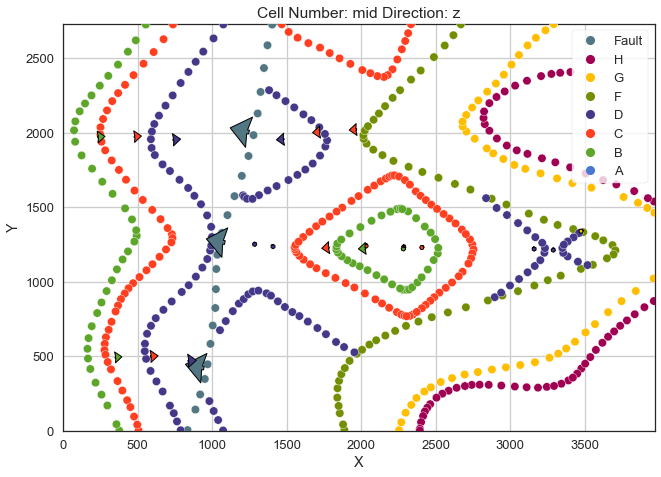

In [39]:
gp.plot_2d(geo_model, direction='z', show_lith=False, show_boundaries=False)
plt.grid()

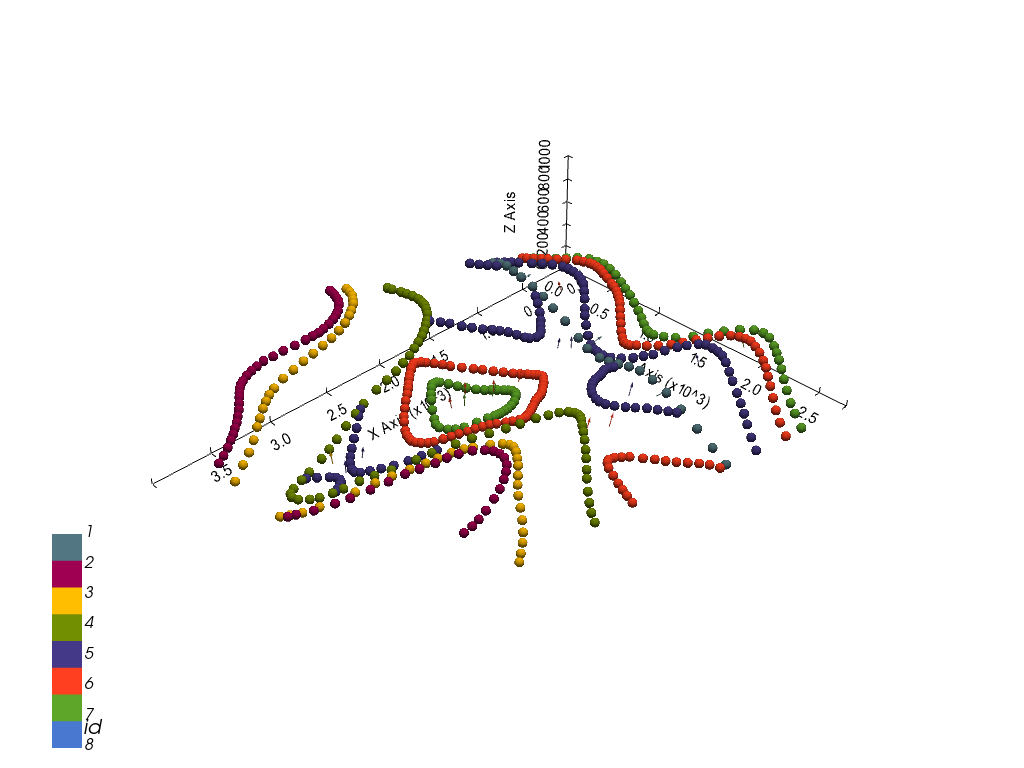

In [40]:
gp.plot_3d(geo_model, image=False, plotter_type='basic', notebook=True)

### Setting the Interpolator

In [41]:
gp.set_interpolator(geo_model,
                    compile_theano=True,
                    theano_optimizer='fast_compile',
                    verbose=[],
                    update_kriging = False
                    )

Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  1
Compilation Done!
Kriging values: 
                     values
range              4919.69
$C_o$            576271.07
drift equations  [3, 3, 3]


### Computing Model

In [42]:
sol = gp.compute_model(geo_model, compute_mesh=True)

### Plotting Cross Sections

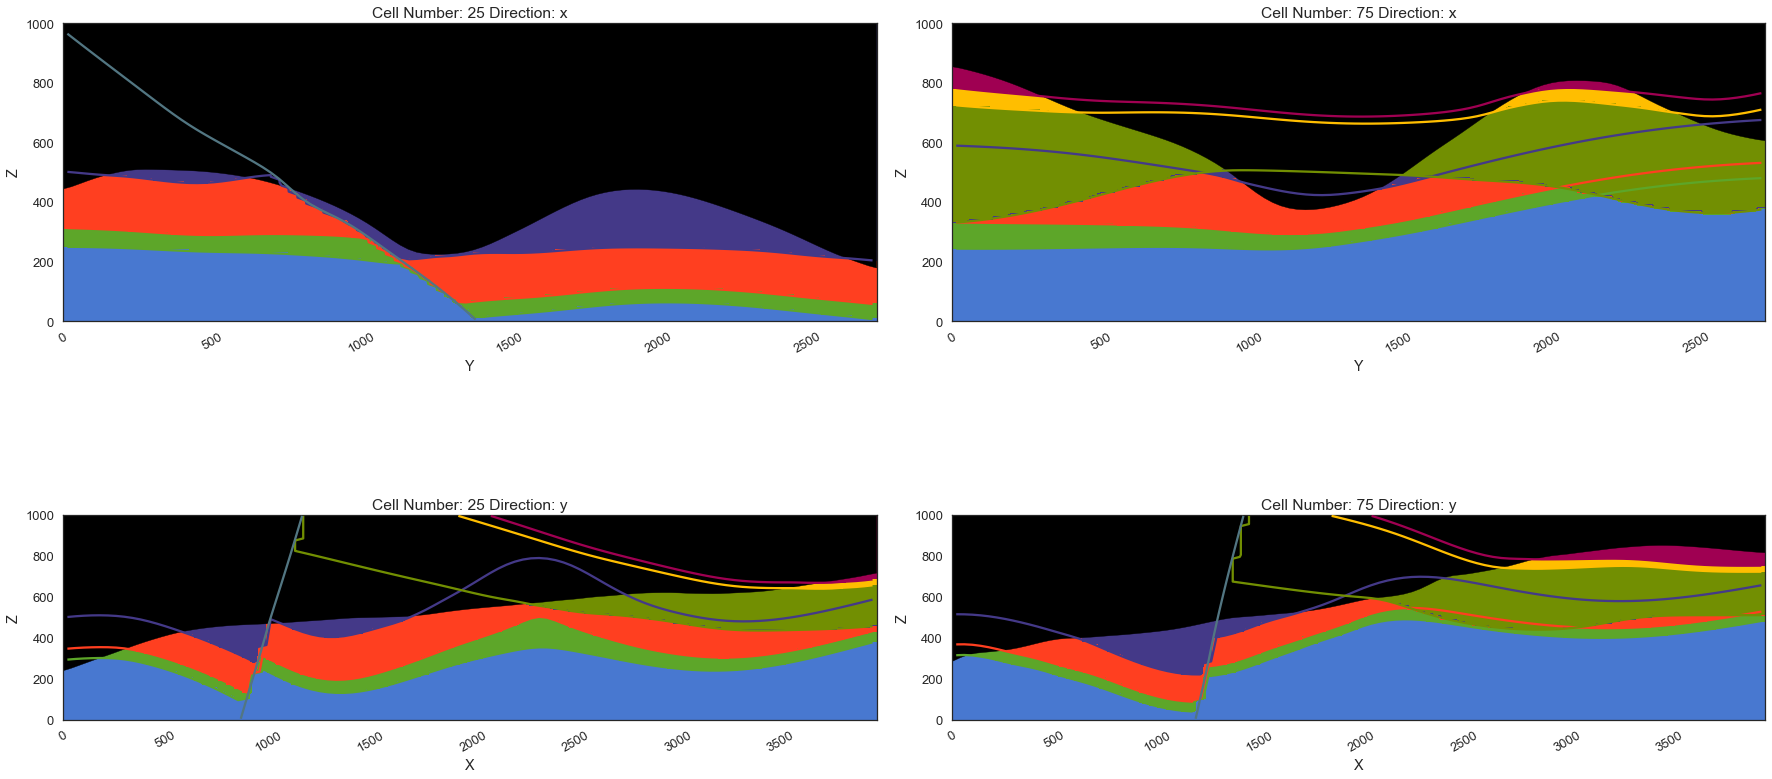

In [43]:
gp.plot_2d(geo_model, direction=['x', 'x', 'y', 'y'], cell_number=[25,75,25,75], show_topography=True, show_data=False)

### Plotting 3D Model

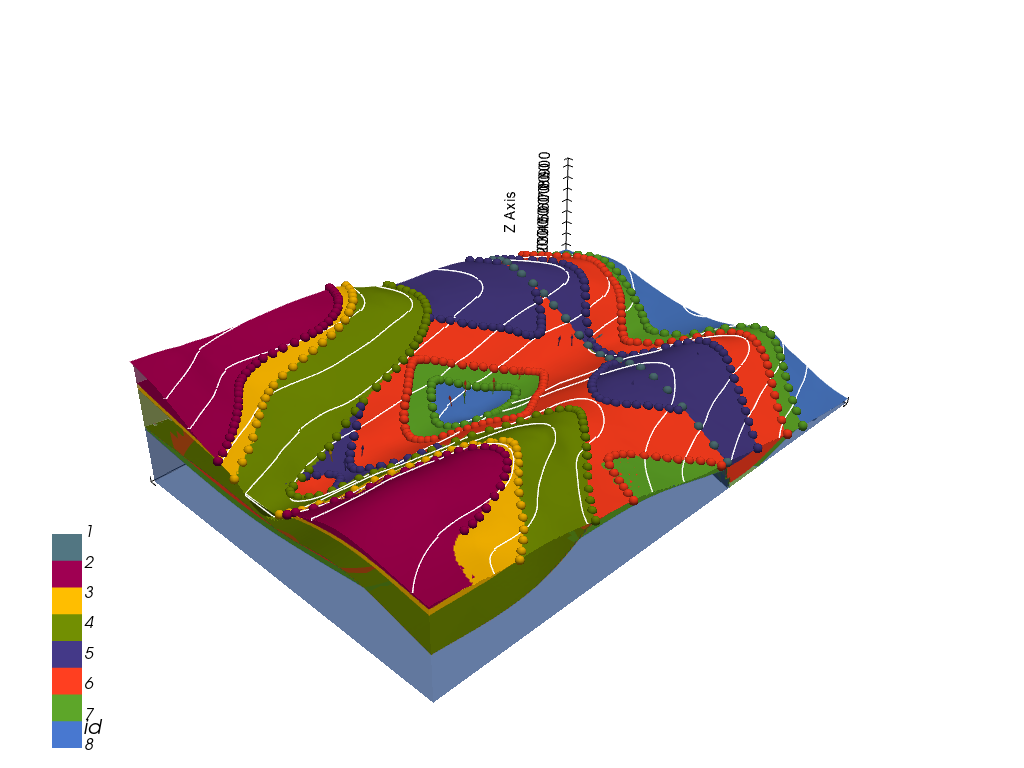

In [44]:
gpv = gp.plot_3d(geo_model, image=False, show_topography=True,
                 plotter_type='basic', notebook=True, show_lith=True)